Optimized scaling values for 1pct-brch-1000PgC:  1.9484040478434017 0.6243726865860229 4.624551124410049 0.3575677586514118
Optimized scaling values for 1pct-brch-2000PgC:  3.1279043721933726 2.270173156591906e-14 4.898820238179501 0.7071582336825616


/var/folders/y3/ppmzlxr96cgcbyrd6tktcljc0000gn/T/ipykernel_38585/4039995350.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scale_and_d_values_df = pd.concat([scale_and_d_values_df, new_scale_values], ignore_index=True)


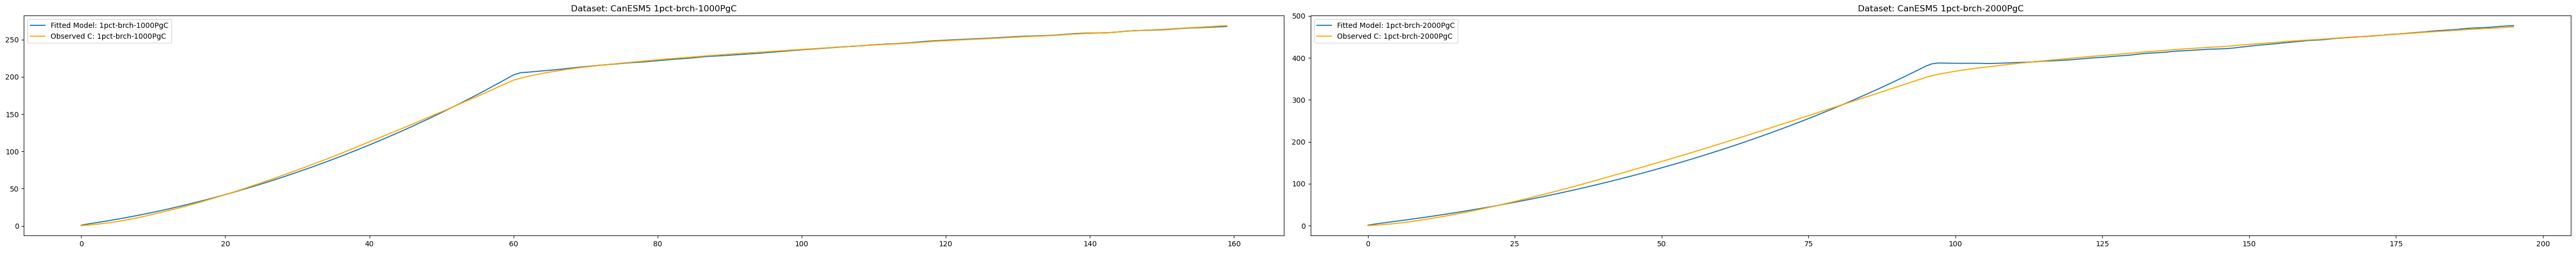

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib import recfunctions
from scipy.optimize import curve_fit

# Define the step temperature functions

# === Step Temperature Function ===
# The function below (`step_temperature_e`) models the temperature response over time due to changes in forcing (e.g., CO2 concentration).
# This concept is similar to the impulse response approach in FaIRv2.0.0, where temperature responds to radiative forcing changes.
# Reference: FaIRv2.0.0, Section 2.4 - Temperature response

def step_temperature_e(S_old, F, q, d, dt=1):
    """
    Calculate the step temperature response with decay over time.

    Parameters:
    - S_old: Previous temperature state.
    - F: Forcing due to CO2 concentrations.
    - q: Scaling parameters for temperature response (analogous to FaIR's q values).
    - d: Decay time constants (analogous to FaIR's d values).
    - dt: Time step, default is 1 year.

    Returns:
    - S_new: Updated temperature state.
    - T: Integrated temperature response.
    """

    decay_factor = np.exp(-dt / d)
    S_new = q * F * (1 - decay_factor) + S_old * decay_factor
    T = np.sum((S_old + S_new) / 2)
    return S_new, T

# Define the fitting function

# === Parameter Scaling Function ===
# The `only_leave_params_to_be_set` function initializes scaling parameters and applies the temperature step model to each timestep.
# It simulates temperature evolution based on emissions data, analogous to FaIR's usage of state-dependent parameters.
# Reference: FaIRv2.0.0, Section 3.1 - Tuning the thermal response
    
def only_leave_params_to_be_set(time, alpha, beta, gamma, delta, conc_data):
    """
    Apply parameter scaling and step temperature function for each timestep to model CO2 impact.

    Parameters:
    - time: Time array.
    - alpha, beta, gamma, delta: Scaling factors to tune `q` and `d` values for fitting.
    - conc_data: Observed concentration data.

    Returns:
    - C_output: Modeled cumulative CO2 emissions over time.
    """

    # Scaling `q` values (response strengths) based on tuning parameters
    q_test = np.array([0.180 * alpha, 0.297 * beta, 0.386 * gamma])  # q values
    
    # Setting `d` values (decay rates) with scaling, similar to FaIR's decay constants for different processes
    d_test = np.array([0.903, 7.92, 355 * delta]) # d values (set)
    # Convert concentration data to deviations from baseline
    C_test_values = np.array(conc_data - 280, dtype=float)

    # Initialize output array for cumulative CO2 emissions
    C_output = np.zeros(len(C_test_values), dtype=float)

    # Run the step model for the first data point
    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    # Iterate over remaining data points
    for t in range(1, len(C_test_values)):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)


# === Fitting Procedure ===
# The following function, `step_temp_model_fitting_procedure`, calibrates the model to fit observed data by adjusting alpha, beta, gamma, and delta.
# This step resembles the FaIRv2.0.0 model’s parameter tuning to replicate the behavior of more complex models or observational data.
# Reference: FaIRv2.0.0, Section 4.1 - Probabilistic parameter ensembles and Section 4.3 - Constraining probabilistic parameter ensembles

def step_temp_model_fitting_procedure(fgco2, conc, datasets, dataset_name, scale_and_d_values_df):
    """
    Fit model parameters to observed CO2 flux and concentration data and plot results.

    Parameters:
    - fgco2: Dictionary of CO2 flux data for different experiments.
    - conc: Dictionary of CO2 concentration data for different experiments.
    - datasets: List of dataset labels (experiment names).
    - dataset_name: Name of the dataset being analyzed.
    - scale_and_d_values_df: DataFrame to store optimized parameter values.

    Returns:
    - plt: Matplotlib plot with fitting results.
    - scale_and_d_values_df: Updated DataFrame with fitted scale and decay values.
    """
    # Set up subplots for visualizing each experiment's data
    # Set up subplots for plotting
    fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

    # Define bounds for parameter fitting and initial guesses
    bounds = (0, [np.inf, np.inf, np.inf, np.inf])
    p0=[1, 1, 1, 1]

    for i, label in enumerate(datasets):
        # Retrieve the observed flux and concentration data
        fgco2_data = fgco2[label]
        C = np.cumsum(fgco2_data) # Cumulative CO2 emissions (analogous to FaIR’s approach to cumulative forcing)

        conc_data = conc[label]
        time = np.arange(len(conc_data))
    
        # Ensure consistent length for fitting
        min_length = min(len(C), len(conc_data))
        C = C[:min_length]
        conc_data = conc_data[:min_length]
        time = time[:min_length]

        # Fit the curve
        # Curve fitting to minimize the difference between modeled and observed cumulative CO2 emissions
        popt, pcov = curve_fit(lambda t, alpha, beta, gamma, delta: only_leave_params_to_be_set(t, alpha, beta, gamma, delta, conc_data), 
                       time, C, p0=p0, bounds=bounds)
    
        # Optimized parameters
        
        alpha_opt, beta_opt, gamma_opt, delta_opt = popt
    
        print(f"Optimized scaling values for {label}: ", alpha_opt, beta_opt, gamma_opt, delta_opt)

        # Append q values to the DataFrame
        # Store optimized parameters in a DataFrame 
        new_scale_values = pd.DataFrame({'Dataset': [f'{dataset_name}'], 'Experiment': [label], 'alpha': [alpha_opt], 'beta': [beta_opt], 'gamma': [gamma_opt], 'delta': [delta_opt]})
    
        # Concatenate the new q values to the main scale_values_df DataFrame
        scale_and_d_values_df = pd.concat([scale_and_d_values_df, new_scale_values], ignore_index=True)
        # Output C with optimized parameters
        C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, delta_opt, conc_data)

        # Plot the fitted curve and observed data
        ax[i].plot(time, C_output_optimized, label=f'Fitted Model: {label}')
        ax[i].plot(time, C, 'orange', label=f'Observed C: {label}')
        ax[i].set_title(f'Dataset: {dataset_name} {label}')
        ax[i].legend()
    

    # Adjust layout and show plot
    plt.tight_layout()
    plt.savefig(f'fitted d3 Dataset: {dataset_name}')
    return plt, scale_and_d_values_df


# Load data
# Load data for each dataset (experiment) on CO2 flux (fgco2) and CO2 concentration (conc).
# These datasets allow exploring oceanic CO2 impact under varied scenarios, akin to FaIRv2.0.0's scenario exploration.
# Reference: FaIRv2.0.0, Section 3 - Emulating complex climate models
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC']

# Load CO2 flux data (fgco2) and concentration data (conc) from CSV files
fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0).to_numpy().flatten(),
}

# Initialize DataFrame for storing optimized parameter values
scale_and_d_values_df = pd.DataFrame(columns=['Dataset', 'Experiment', 'alpha', 'beta', 'gamma', 'delta'])

# Execute the fitting procedure and plot results
plt , scale_values_df = step_temp_model_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'CanESM5', scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pctCO2:  4.490354696356686 2.2422836534447008e-10 3.13812308749964e-09 64.23959602819636
Optimized scaling values for 1pct-brch-1000PgC:  2.5241892808414095 0.5189993115273589 5.085831064863782 0.39929537098824575
Optimized scaling values for 1pct-brch-750PgC:  1.3843937202677126 1.264748952514266 5.302745256177467 0.352924825140562


/var/folders/y3/ppmzlxr96cgcbyrd6tktcljc0000gn/T/ipykernel_38585/4039995350.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scale_and_d_values_df = pd.concat([scale_and_d_values_df, new_scale_values], ignore_index=True)


Optimized scaling values for 1pct-brch-2000PgC:  3.944623664567347 1.3115021980540516e-30 15295.642495285649 4064.7506644680298


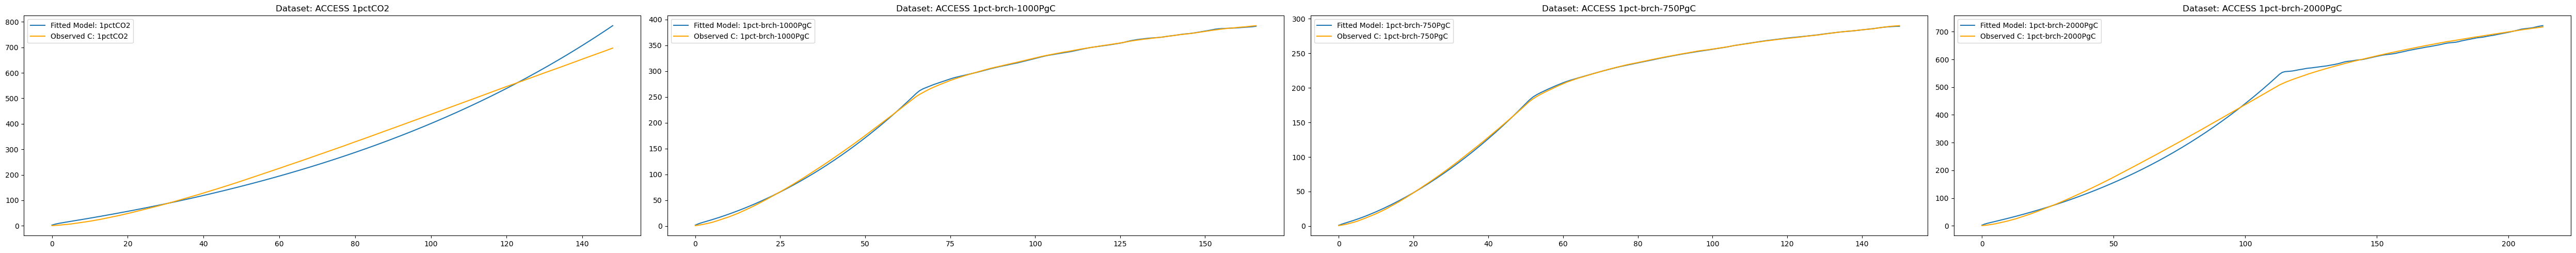

In [31]:
# === Load New Data for Different Scenarios ===
# This block loads CO2 flux and concentration data for additional scenarios (`1pctCO2`, `1pct-brch-1000PgC`, etc.).
# These scenarios, similar to those in FaIR, allow the model to assess responses under different levels of CO2 forcing.
# Reference: FaIRv2.0.0, Section 3.3 - Scenario testing and aerosol forcing parameterization

# Load data
# Define new scenarios to analyse
datasets = ['1pctCO2', '1pct-brch-1000PgC', '1pct-brch-750PgC', '1pct-brch-2000PgC']

# === Load Flux Data (fgco2) ===
# Loading data for oceanic CO2 flux (`fgco2`) for each scenario. Each dataset represents a unique experimental setup
# with differing levels of CO2 forcing or emissions.
# Reference: In FaIRv2.0.0, similar data loading is used to test model behavior under various socio-economic scenarios (see Section 4).


fgco2 = {
    '1pctCO2': pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/fgco2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/fgco2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/fgco2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/fgco2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
}

# === Load Concentration Data (conc) ===
# Load CO2 concentration data (`conc`) for each scenario. These observed concentration levels are used for fitting,
# as FaIRv2.0.0 also relies on concentration data to parameterize responses under different climate scenarios.
# Reference: FaIRv2.0.0, Section 2.1.2 - Historical and SSP concentration trajectories

conc = {
    '1pctCO2': pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/co2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/co2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/co2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
}


# === Execute Fitting Procedure for ACCESS Data ===
# The `step_temp_model_fitting_procedure` function applies curve fitting to match model output to observed flux and concentration data.
# This process is analogous to FaIRv2.0.0's calibration of model parameters against observed datasets.
# Reference: FaIRv2.0.0, Section 4.1 - The current level and rate of warming and probabilistic calibration with observations

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'ACCESS', scale_and_d_values_df = scale_and_d_values_df)


Optimized scale values for 1pct-brch-1000PgC:  1.9823067961575496 0.5695520404262522 5.697297453161548 0.5168356623311527


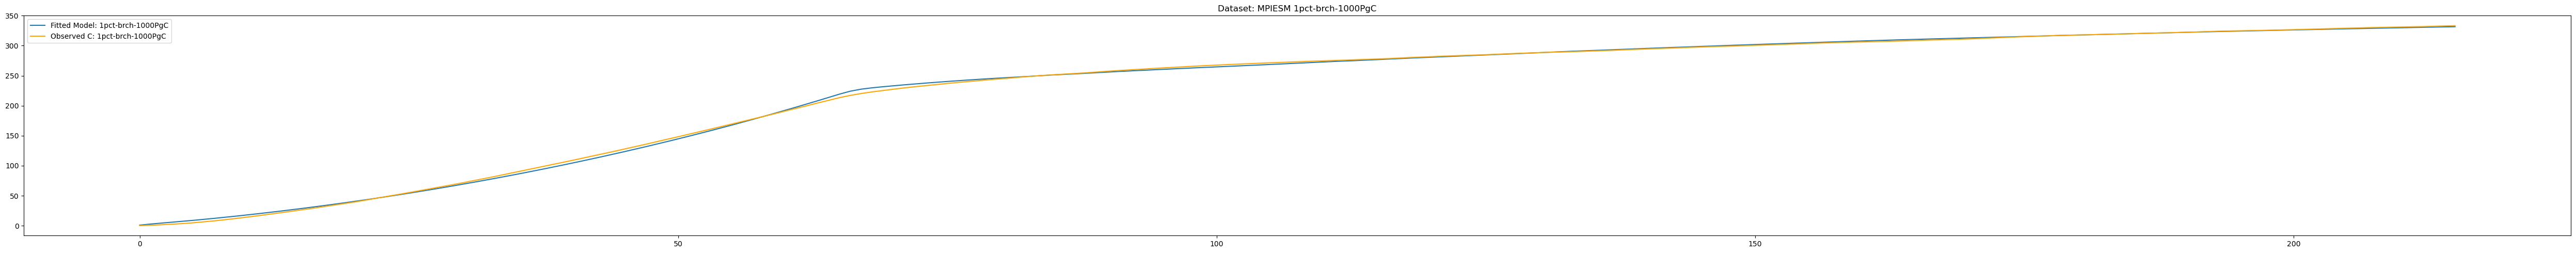

In [3]:
# Load data
# === Load Data for CESM Scenario ===
# This block loads oceanic CO₂ flux (`fgco2`) and concentration (`conc`) data specifically for the '1pct-brch-1000PgC' scenario.
# This is similar to the scenario-based approach in FaIRv2.0.0, where different datasets allow testing model responses across varied emission scenarios.
# Reference: FaIRv2.0.0, Section 3 - Emulating complex climate models

datasets = ['1pct-brch-1000PgC']

# Load CO₂ flux data for '1pct-brch-1000PgC'
fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CESM/CESM_A1/fgco2_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', index_col=0).to_numpy().flatten(),
}

# Load CO₂ concentration data for '1pct-brch-1000PgC'
conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CESM/CESM_A1/co2_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', index_col=0).to_numpy().flatten(),
}

# Set up subplots for plotting
# === Initialising Subplots for Visualisation ===
# Create subplots to visualise model fitting results for each dataset in a single row

fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

# === Fitting and Optimising Model Parameters ===
# Iterate through each dataset to fit the model using a curve-fitting procedure that optimises alpha, beta, gamma, and delta.
# This aligns with FaIRv2.0.0's parameter tuning approach to ensure the model accurately reflects observed data.
# Reference: FaIRv2.0.0, Section 4.1 - Probabilistic parameter calibration with observed data

for i,label in enumerate(datasets):
    # Extract the flux data and compute cumulative CO₂ emissions (C) to match the observed dataset's timescale
    fgco2_data = fgco2[label]
    C = np.cumsum(fgco2_data)

    # Extract the concentration data and initialise time variable
    conc_data = conc[label]
    time = np.arange(len(conc_data))
    
    # Ensure consistent length for fitting
    min_length = min(len(C), len(conc_data))
    C = C[:min_length]
    conc_data = conc_data[:min_length]
    time = time[:min_length]

    # Fit the curve
    # Fit the model to observed data by optimising alpha, beta, gamma, and delta
    # This fitting process is similar to FaIR's procedure of adjusting decay and feedback factors to match real-world observations.

    popt, pcov = curve_fit(lambda t, alpha, beta, gamma, delta: only_leave_params_to_be_set(t, alpha, beta, gamma, delta, conc_data), 
                       time, C, p0=[1,1,1, 1], bounds = (0, [np.inf, np.inf, np.inf, np.inf]))
    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt, delta_opt = popt
    print(f"Optimized scale values for {label}: ", alpha_opt, beta_opt, gamma_opt, delta_opt)
    
    # Append q values to the DataFrame
    # Store optimised parameters in a DataFrame to record results for further analysis
    new_scale_values = pd.DataFrame({
        'Dataset': ['CESM'],
        'Experiment': [label],
        'alpha': [alpha_opt],
        'beta': [beta_opt],
        'gamma': [gamma_opt],
        'delta': [delta_opt]
    })
    
    # Append these values to the main DataFrame holding all optimised scale parameters
    # Concatenate the new q values to the main q_values_df DataFrame
    scale_and_d_values_df = pd.concat([scale_and_d_values_df, new_scale_values], ignore_index=True)
    # Output C with optimized parameters
    C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, delta_opt, conc_data)

    # === Visualising Model vs Observed Data ===
    # Plot the optimised model output against observed cumulative CO₂ emissions
    ax.plot(time, C_output_optimized, label=f'Fitted Model: {label}')
    ax.plot(time, C, 'orange', label=f'Observed C: {label}')
    ax.set_title(f'Dataset: MPIESM {label}')
    ax.legend()

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('Dataset: CESM')
plt.show()


Optimized scale values for 1pct-brch-1000PgC:  2.028250075846987 0.5842940430416718 8.107927724678586 0.6035124579842396


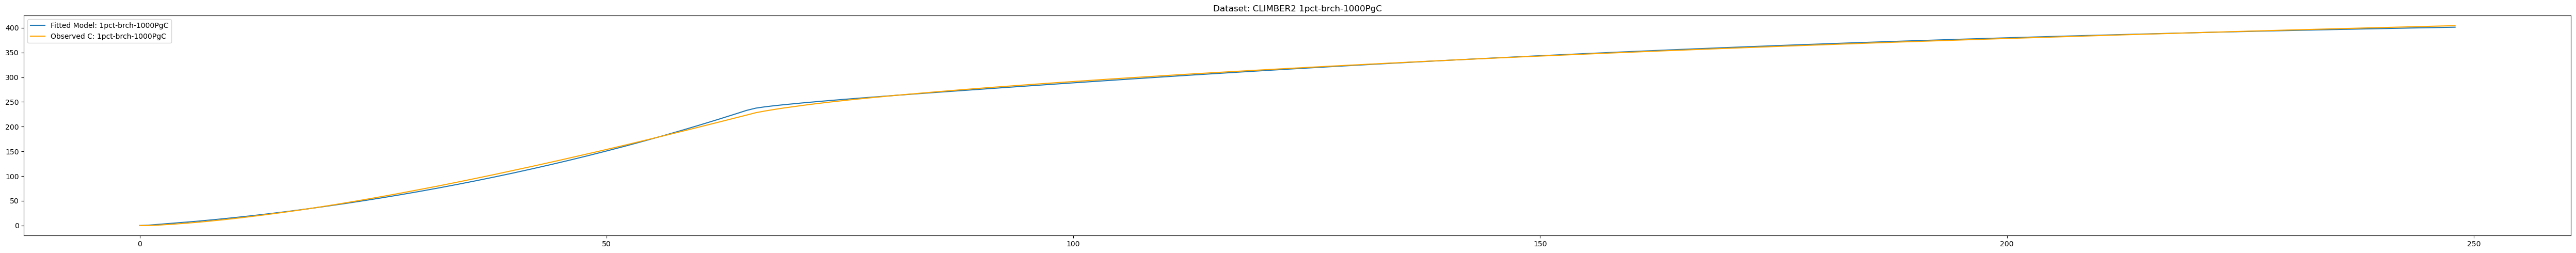

In [4]:
# Load data
# === Load Data for CNRM-ESM2-1 Model Scenarios ===
# This block loads CO₂ flux (`fgco2`) and concentration (`conc`) data for two scenarios: `1pctCO2` and `1pct-brch-1000PgC`.
# The datasets represent specific experimental conditions, allowing the model to simulate and test responses to varied CO₂ forcing.
# Reference: FaIRv2.0.0, Section 2.1 - Gas cycle and Section 4.1 - Scenario and probabilistic parameter ensembles

datasets = ['1pct-brch-1000PgC']


# === Load CO₂ Flux Data (fgco2) ===
# Here, we load CO₂ flux data for the `1pctCO2` and `1pct-brch-1000PgC` scenarios. This data allows the model to track cumulative CO₂ emissions, 
# aligning with FaIR's method of simulating the effects of varying emissions on climate variables.
# Reference: FaIRv2.0.0, Section 4.3 - Scenario-dependent parameter tuning with emissions data

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CLIMBER2/CLIMBER2_A1/fgco2_CLIMBER2_esm-1pct-brch-1000PgC_1850_2100.csv', index_col=0).to_numpy().flatten(),
}


# === Load CO₂ Concentration Data (conc) ===
# Load CO₂ concentration data for the same two scenarios. Concentration data provides input for comparing model output with observed atmospheric levels.
# In FaIRv2.0.0, concentration datasets are similarly used for calibration to ensure the model aligns with observed or projected concentrations.
# Reference: FaIRv2.0.0, Section 2.1.2 - Historical and SSP concentration trajectories

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CLIMBER2/CLIMBER2_A1/co2_CLIMBER2_esm-1pct-brch-1000PgC_1850_2100.csv', index_col=0).to_numpy().flatten(),
}

# === Execute Fitting Procedure for CNRM-ESM2-1 Data ===
# The function `step_temp_model_fitting_procedure` applies the curve fitting process to the loaded data, optimising model parameters to align with observed trends.
# This fitting method is similar to the FaIRv2.0.0 model’s parameter calibration, where model outputs are fitted against historical or modelled datasets.
# Reference: FaIRv2.0.0, Section 4.1 - Calibration with observational data for probabilistic projection


# Set up subplots for plotting
fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

for i,label in enumerate(datasets):
    fgco2_data = fgco2[label]
    C = np.cumsum(fgco2_data)

    conc_data = conc[label]
    time = np.arange(len(conc_data))
    
    # Ensure consistent length for fitting
    min_length = min(len(C), len(conc_data))
    C = C[:min_length]
    conc_data = conc_data[:min_length]
    time = time[:min_length]

    # Fit the curve
    popt, pcov = curve_fit(lambda t, alpha, beta, gamma, delta: only_leave_params_to_be_set(t, alpha, beta, gamma, delta, conc_data), 
                       time, C, p0=[1,1,1, 1], bounds = (0, [np.inf, np.inf, np.inf, np.inf]))
    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt, delta_opt = popt
    print(f"Optimized scale values for {label}: ", alpha_opt, beta_opt, gamma_opt, delta_opt)
    
    # Append q values to the DataFrame
    new_scale_values = pd.DataFrame({
        'Dataset': ['MPIESM'],
        'Experiment': [label],
        'alpha': [alpha_opt],
        'beta': [beta_opt],
        'gamma': [gamma_opt],
        'delta': [delta_opt]
    })
    
    # Concatenate the new q values to the main q_values_df DataFrame
    scale_and_d_values_df = pd.concat([scale_and_d_values_df, new_scale_values], ignore_index=True)
    # Output C with optimized parameters
    C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, delta_opt, conc_data)

    # Plot the fitted curve and observed data
    ax.plot(time, C_output_optimized, label=f'Fitted Model: {label}')
    ax.plot(time, C, 'orange', label=f'Observed C: {label}')
    ax.set_title(f'Dataset: CLIMBER2 {label}')
    ax.legend()

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('Dataset: CLIMBER2')
plt.show()


Optimized scaling values for 1pctCO2:  3.001431363064993 1.2260487199497513e-10 9.57406941637673e-13 128.15377528809228
Optimized scaling values for 1pct-brch-1000PgC:  1.2666622712416709 4.065040790978017e-15 3.097937879188565 0.22291503004757485


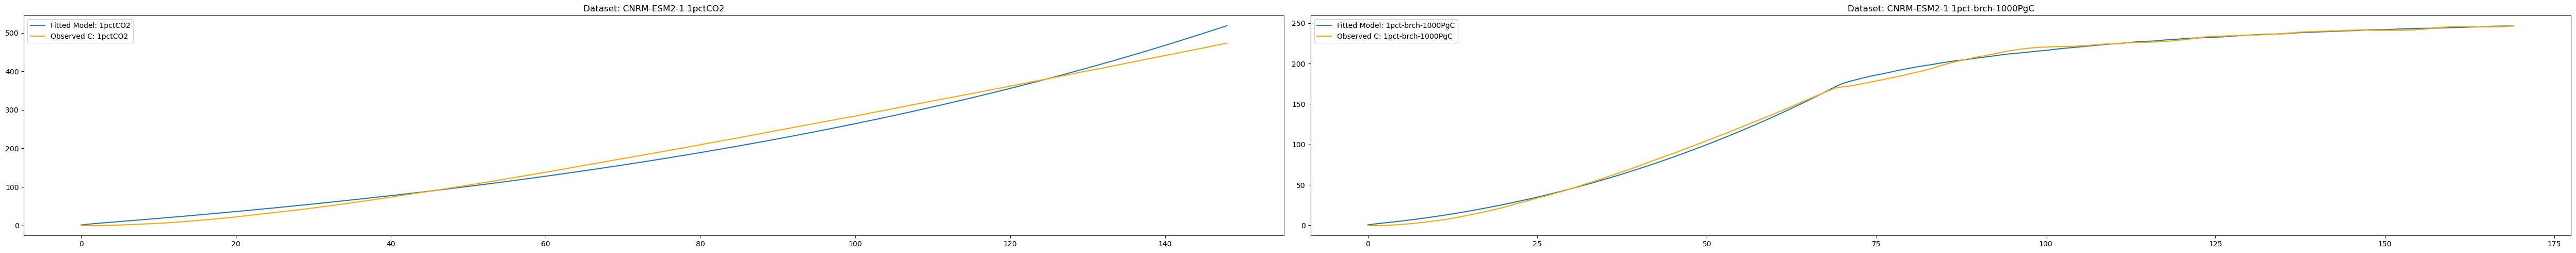

In [5]:
# === Load Data for DCESS Model Scenarios ===
# This block loads CO₂ flux (`fgco2`) and concentration (`conc`) data for several scenarios from the DCESS model.
# These scenarios, including '1pct-brch' and 'bell', represent different cumulative carbon emissions over time and allow
# us to observe the model's temperature response to various forcing conditions.
# Reference: FaIRv2.0.0, Section 3 - Scenario-based emissions and concentrations, where different emissions scenarios 
# test model response accuracy.
datasets = ['1pctCO2', '1pct-brch-1000PgC']

# === Load CO₂ Flux Data (fgco2) ===
# Loading flux data for each specified scenario. This flux data is used to calculate cumulative CO₂ emissions, 
# mirroring FaIRv2.0.0's method of aggregating emissions to model how they drive temperature change.
# Reference: FaIRv2.0.0, Section 2.3 - Calculating effective radiative forcing (ERF) and cumulative emissions.

fgco2 = {
    '1pctCO2': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_1pctCO2/fgco2_CNRM-ESM2-1_1pctCO2_r1i1p1_185001-199912.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_ZECMIP/fgco2_CNRM-ESM2-1_esm-1pct-brch-1000PgC_r1i1p1_192001-202012.csv', index_col=0).to_numpy().flatten(),
}


# === Load CO₂ Concentration Data (conc) ===
# Loading concentration data for each scenario. This data is used for model fitting, as the model adjusts its parameters
# to align with observed concentration values, similar to FaIR's tuning of concentration-based scenarios.
# Reference: FaIRv2.0.0, Section 4.3 - Constraining parameter ensembles to align with observed concentrations.

conc = {
    '1pctCO2': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_1pctCO2/co2_CNRM-ESM2-1_1pctCO2_r1i1p1_185001-199912.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_ZECMIP/co2_CNRM-ESM2-1_esm-1pct-brch-1000PgC_r1i1p1_192001-202012.csv', index_col=0).to_numpy().flatten(),
}

# === Execute Fitting Procedure for DCESS Data ===
# This code runs the `step_temp_model_fitting_procedure`, which uses curve fitting to optimise model parameters so that the 
# model’s temperature response matches observed data for each scenario. This reflects FaIR's probabilistic parameter 
# calibration process that aligns model output with observed or simulated climate data.
# Reference: FaIRv2.0.0, Section 4.1 - Calibration and validation using observational and historical data.

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'CNRM-ESM2-1', scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  6.267524288558351e-18 2.2500488377946644 13.42225077388698 1.7336794255638865
Optimized scaling values for 1pct-brch-2000PgC:  1.5034769386629439 1.0856194879743881 13.721453343162144 2.4095340270153023
Optimized scaling values for 1pct-brch-750PgC:  2.1206905639109042e-19 2.2993086870536157 12.303505934193232 1.4608649348283305
Optimized scaling values for bell-1000PgC:  4.779516063973128e-17 2.18691299604713 13.432264696358265 1.7309410490487904
Optimized scaling values for bell-2000PgC:  0.5602426210673057 1.442423972709866 13.691879332744442 2.3703780854875305
Optimized scaling values for bell-750PgC:  1.2355664755240974e-17 2.2597165482855557 12.32809777305354 1.47432563208878


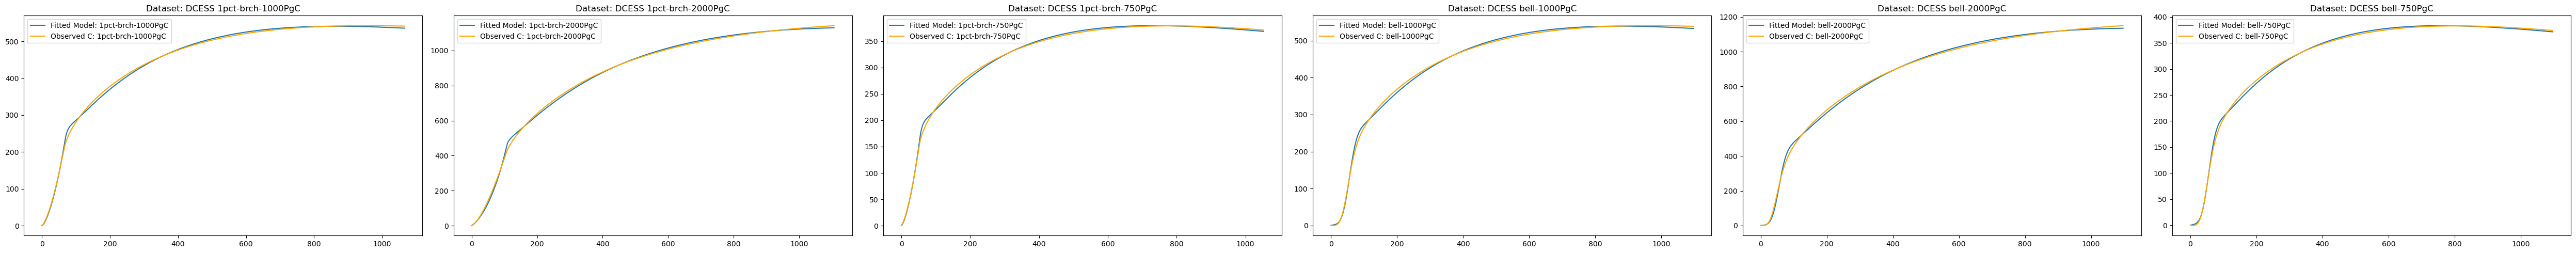

In [6]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_1000PgC/fgco2_DCESS1.0_esm-1pct-brch-1000PgC_1765-2833.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_2000PgC/fgco2_DCESS1.0_esm-1pct-brch-2000PgC_1765_2874.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_750PgC/fgco2_DCESS1.0_esm-1pct-brch-750PgC_1765_2820.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_1000PgC/fgco2_DCESS1.0_esm-bell-1000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_2000PgC/fgco2_DCESS1.0_esm-bell-2000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_750PgC/fgco2_DCESS1.0_esm-bell-750PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_1000PgC/co2_DCESS1.0_esm-1pct-brch-1000PgC_1765-2833.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_2000PgC/co2_DCESS1.0_esm-1pct-brch-2000PgC_1765_2874.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_750PgC/co2_DCESS1.0_esm-1pct-brch-750PgC_1765_2820.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_1000PgC/co2_DCESS1.0_esm-bell-1000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_2000PgC/co2_DCESS1.0_esm-bell-2000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_750PgC/co2_DCESS1.0_esm-bell-750PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'DCESS', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  6.21040781945956e-22 2.6057936104281265 12.692996835038686 1.2121299447741232
Optimized scaling values for 1pct-brch-2000PgC:  2.650056935248602 0.6704853730134951 10.58194690258578 1.3932430077564761
Optimized scaling values for 1pct-brch-750PgC:  1.396952234454174e-18 2.636504452206188 12.4129236151752 1.0809508607815863
Optimized scaling values for bell-1000PgC:  6.202930651982738e-19 2.5118458025493067 12.393803715470169 1.1570017994335926
Optimized scaling values for bell-2000PgC:  1.3907125742943562 1.1384025844158912 10.468236734411834 1.3533160508724067
Optimized scaling values for bell-750PgC:  1.3433162731855416e-21 2.6052607489191426 12.36112794309668 1.0623245200211002


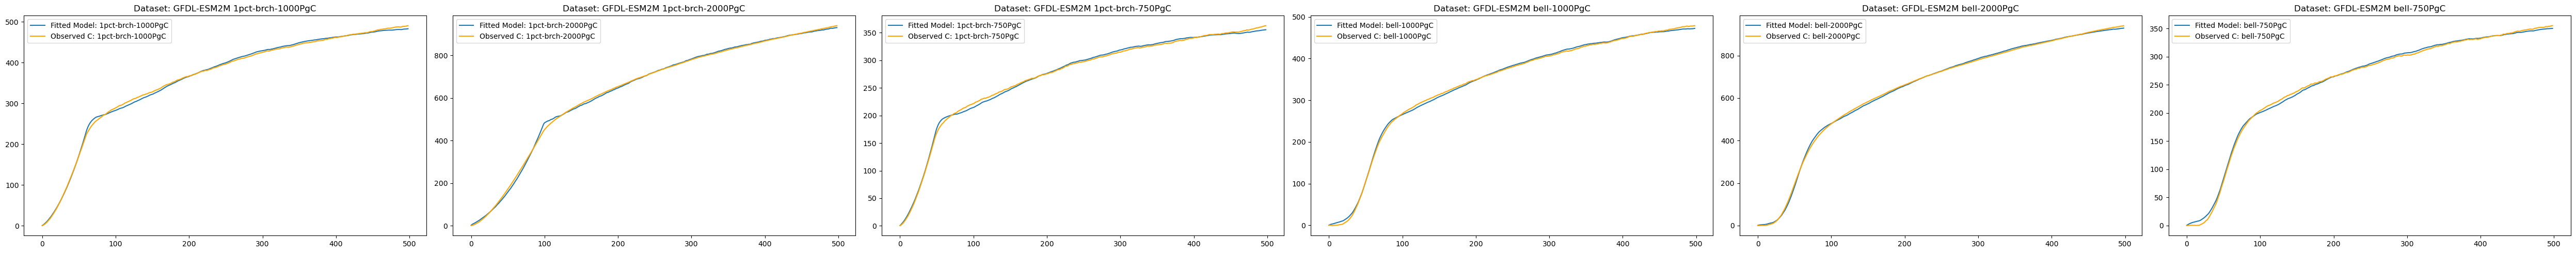

In [7]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'GFDL-ESM2M', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  4.050813370084379e-24 0.23015813925802456 12.090979304680722 0.5986183329607944
Optimized scaling values for 1pct-brch-2000PgC:  1.633723223671068e-14 0.5165207735541469 9.276587860499191 0.5176224141208502
Optimized scaling values for 1pct-brch-750PgC:  8.188592665806116e-17 0.163948895628616 12.770566801002046 0.6150869801847151
Optimized scaling values for bell-1000PgC:  1.7388378529566002e-20 0.1836786913533736 11.8915830173352 0.5922172728734947
Optimized scaling values for bell-2000PgC:  2.257015137512563e-18 0.38966191819079493 9.257789404826825 0.5130126348057595
Optimized scaling values for bell-750PgC:  7.086937793032743e-16 0.11016455565980131 12.474079195694065 0.6065425992514426


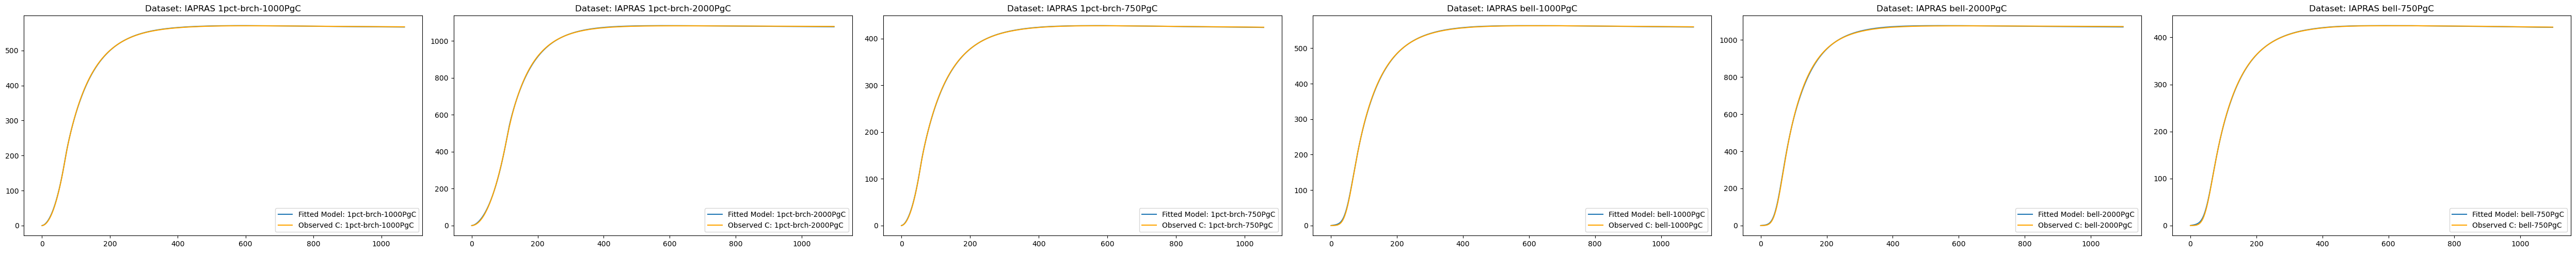

In [8]:
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-1000PgC/fgco2_IAPRAS_esm-1pct-brch-1000PgC_1_1070.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-2000PgC/fgco2_IAPRAS_esm-1pct-brch-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-750PgC/fgco2_IAPRAS_esm-1pct-brch-750PgC_1_1057.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-1000PgC/fgco2_IAPRAS_esm-bell-1000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-2000PgC/fgco2_IAPRAS_esm-bell-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/IAPRAS/bell-750PgC/fgco2_IAPRAS_esm-bell-750PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-1000PgC/co2_IAPRAS_esm-1pct-brch-1000PgC_1_1070.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-2000PgC/co2_IAPRAS_esm-1pct-brch-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-750PgC/co2_IAPRAS_esm-1pct-brch-750PgC_1_1057.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-1000PgC/co2_IAPRAS_esm-bell-1000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-2000PgC/co2_IAPRAS_esm-bell-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/IAPRAS/bell-750PgC/co2_IAPRAS_esm-bell-750PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'IAPRAS', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  2.6991710802519005e-19 2.260983428256111 13.072037649609909 2.1231192044905556
Optimized scaling values for 1pct-brch-750PgC:  1.675854841238998e-18 2.3315627853475287 12.038203119559437 1.7351022428156837


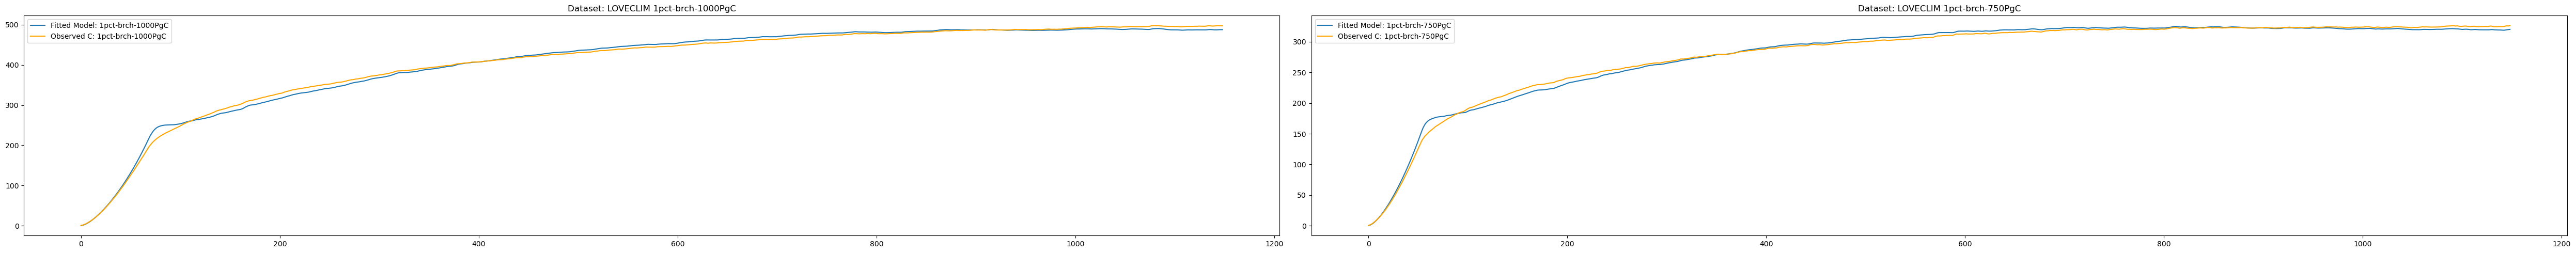

In [9]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM1000PgCNew/fgco2_LOVECLIM_esm-1pct-brch-1000PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM750PgCNew/fgco2_LOVECLIM_esm-1pct-brch-750PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM1000PgCNew/co2_LOVECLIM_esm-1pct-brch-1000PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM750PgCNew/co2_LOVECLIM_esm-1pct-brch-750PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'LOVECLIM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  3.970243880177924e-19 2.587268015701499 13.227256475815668 1.1087642042541113
Optimized scaling values for 1pct-brch-2000PgC:  3.093840365815229e-18 2.5212693717320174 10.509470584469764 1.2326523312467348
Optimized scaling values for 1pct-brch-750PgC:  3.2043910068505184e-20 2.588545463204567 13.900790628653962 1.0754088208525965
Optimized scaling values for bell-1000PgC:  8.585047442309923e-18 2.490575311378839 13.269800781055753 1.1037324805341127
Optimized scaling values for bell-2000PgC:  3.101478939332456e-19 2.1579003646975403 10.711831706411239 1.2173272793542738
Optimized scaling values for bell-750PgC:  5.924172421334341e-16 2.5492532514487625 13.904935954536555 1.0727390743412855


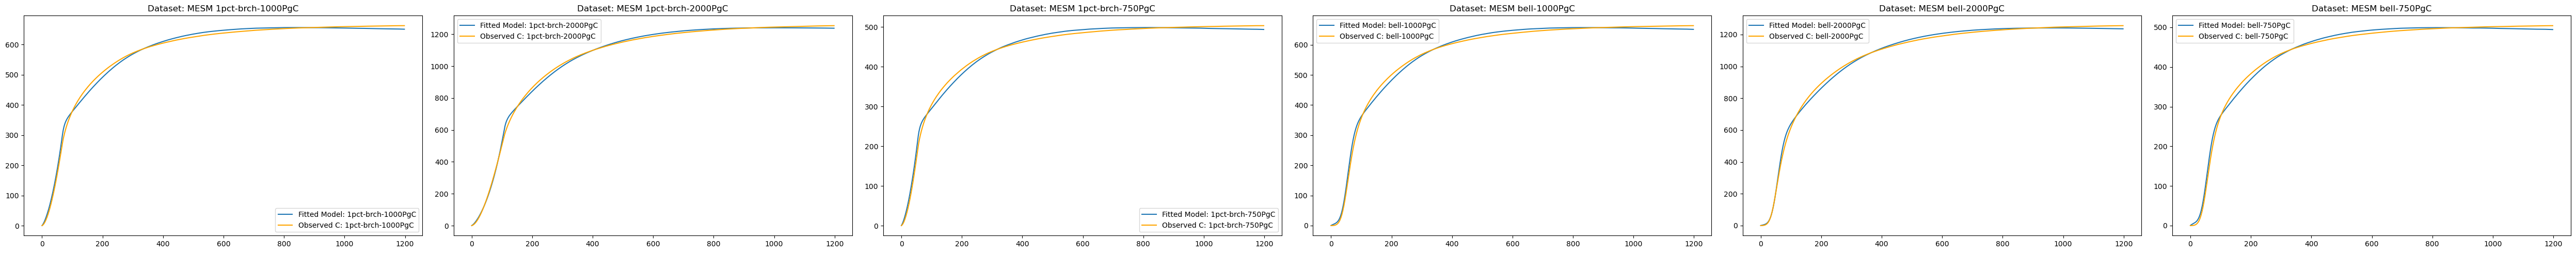

In [10]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%1000GtC/fgco2_MESM_esm-1pct-brch-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%2000GtC/fgco2_MESM_esm-1pct-brch-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%750GtC/fgco2_MESM_esm-1pct-brch-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_1000/fgco2_MESM_esm-bell-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_2000/fgco2_MESM_esm-bell-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_750/fgco2_MESM_esm-bell-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%1000GtC/co2_MESM_esm-1pct-brch-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%2000GtC/co2_MESM_esm-1pct-brch-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%750GtC/co2_MESM_esm-1pct-brch-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_1000/co2_MESM_esm-bell-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_2000/co2_MESM_esm-bell-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_750/co2_MESM_esm-bell-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'MESM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  1.8851139104465973 1.0387905978252108 12.388655773985297 1.2759112388595526
Optimized scaling values for 1pct-brch-2000PgC:  3.3226123475065137 1.858973862198091e-18 9.106972328211551 1.5843511328340678
Optimized scaling values for 1pct-brch-750PgC:  1.0288106768315148 1.7045526058941498 15.803608937673307 1.4955070322228525
Optimized scaling values for 1pctCO2:  4.370185006429651 1.4478670392498447e-12 7.974864688026098e-12 128.14156757038177


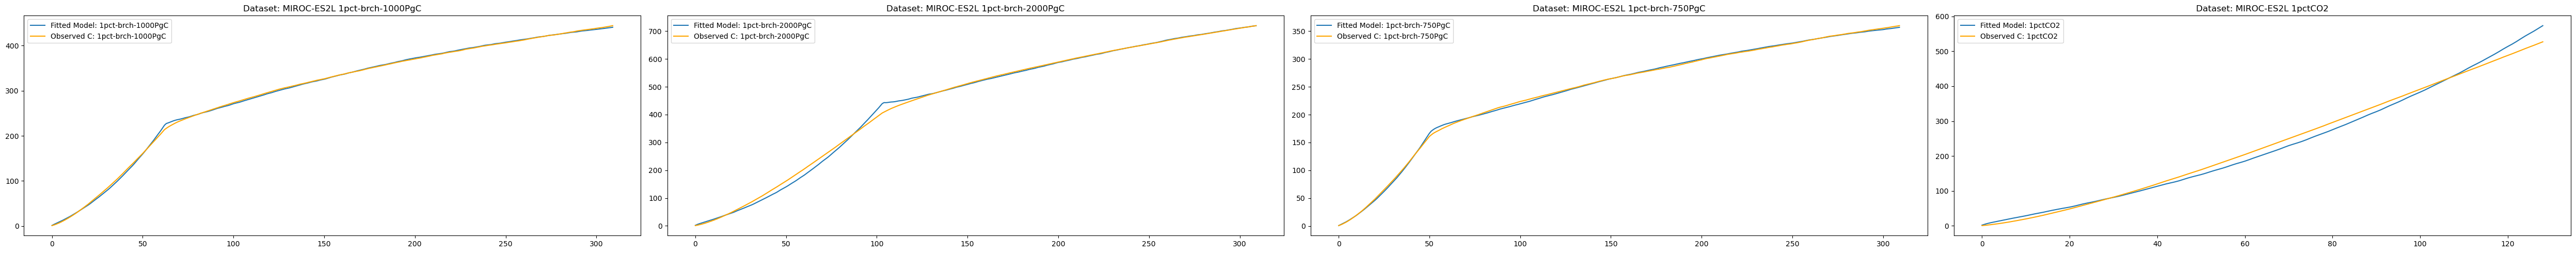

In [11]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', '1pctCO2']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-1000PgC_1913_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-2000PgC_1954_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-750PgC_1901_2160.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/MIROC-ES2L/MIROC-1pct/fgco2_MIROC-ES2L_esm-1pct-brch-1ppy_1850_1979.csv', index_col=0).to_numpy().flatten(),
    }

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-1000PgC_1913_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-2000PgC_1954_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-750PgC_1901_2160.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/MIROC-ES2L/MIROC-1pct/co2_MIROC-ES2L_esm-1pct-brch-1ppy_1850_1979.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'MIROC-ES2L', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  9.261275736148166e-16 3.14312325697972 21.463354642639274 1.826640162956048
Optimized scaling values for 1pct-brch-2000PgC:  2.307236215932914 1.3099464257374447 18.6402269912022 2.0896981304612683
Optimized scaling values for 1pct-brch-750PgC:  1.4246683555191382e-20 3.2509069087963365 22.08327238650592 1.7695224778247234
Optimized scaling values for bell-1000PgC:  1.2823957953799e-15 3.082046207291416 21.480882489026023 1.8188450443593647
Optimized scaling values for bell-2000PgC:  0.7541048294628627 1.9790461402923771 18.783772100759137 2.1091954951385694
Optimized scaling values for bell-750PgC:  1.740520987788561e-19 3.248090349931776 22.0934127171445 1.7701305836531522


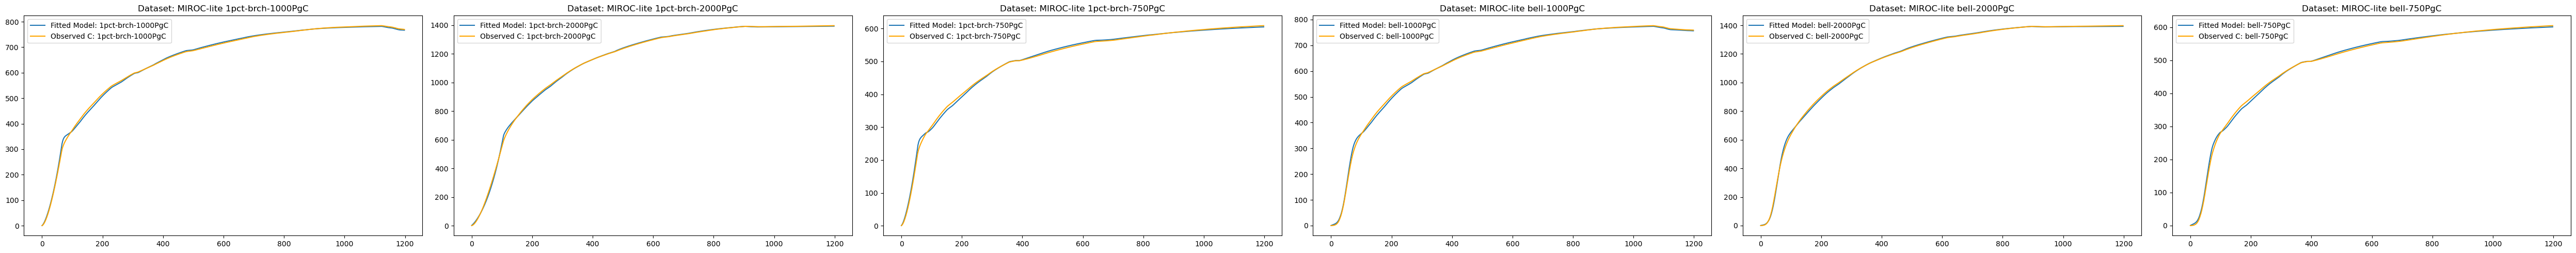

In [12]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/A1_zec_1000PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-1000PgC_66-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-lite/A2_zec_750PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-750PgC_54-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/A3_zec_2000PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-2000PgC_106-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/B1_bellshape_1000PgC/fgco2_MIROC-lite-LCM_esm-bell-1000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MIROC-lite/B2_bellshape_750PgC/fgco2_MIROC-lite-LCM_esm-bell-750PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/B3_bellshape_2000PgC/fgco2_MIROC-lite-LCM_esm-bell-2000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/A1_zec_1000PgC/co2_MIROC-lite-LCM_esm-1pct-brch-1000PgC_66-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-lite/A2_zec_750PgC/co2_MIROC-lite-LCM_esm-1pct-brch-750PgC_54-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/A3_zec_2000PgC/co2_MIROC-lite-LCM_esm-1pct-brch-2000PgC_106-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/B1_bellshape_1000PgC/co2_MIROC-lite-LCM_esm-bell-1000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MIROC-lite/B2_bellshape_750PgC/co2_MIROC-lite-LCM_esm-bell-750PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/B3_bellshape_2000PgC/co2_MIROC-lite-LCM_esm-bell-2000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'MIROC-lite', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scale values for 1pct-brch-1000PgC:  2.1097084274398625 0.6520617301685202 8.970924345243704


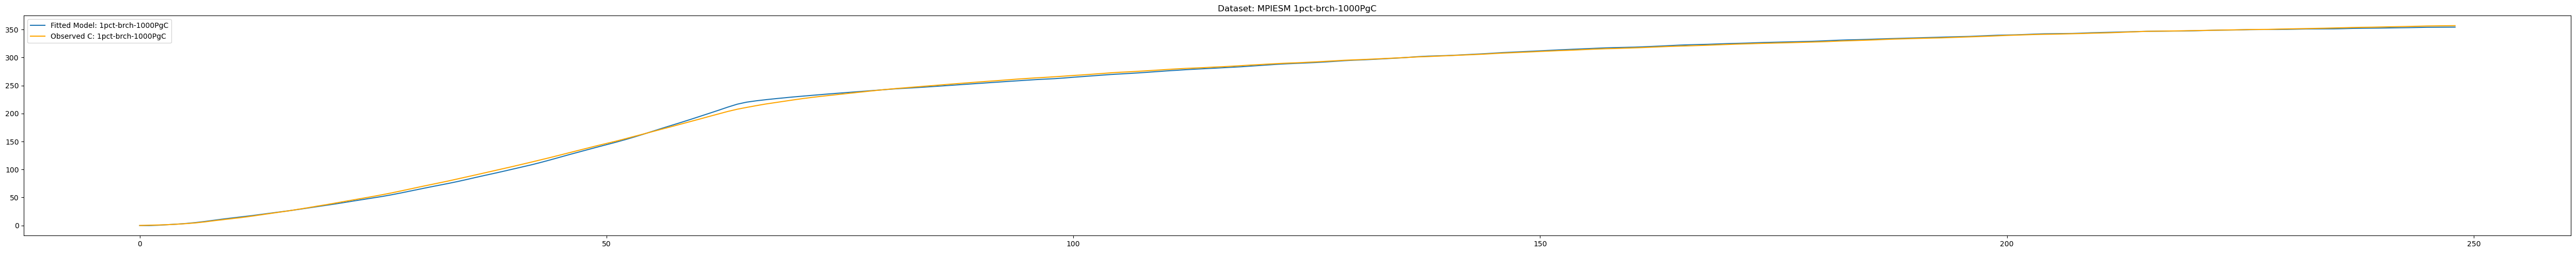

In [13]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MPIESM/MPIESM_A1/fgco2_MPIESM_esm-1pct-brch-1000PgC_1850-2099.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MPIESM/MPIESM_A1/co2_MPIESM_esm-1pct-brch-1000PgC_1850-2099.csv', index_col=0).to_numpy().flatten(),
}

# Set up subplots for plotting
fig, ax = plt.subplots(1, len(datasets), figsize=(50, 5))

for i,label in enumerate(datasets):
    fgco2_data = fgco2[label]*-1
    C = np.cumsum(fgco2_data)

    conc_data = conc[label]
    time = np.arange(len(conc_data))
    
    # Ensure consistent length for fitting
    min_length = min(len(C), len(conc_data))
    C = C[:min_length]
    conc_data = conc_data[:min_length]
    time = time[:min_length]

    # Fit the curve
    popt, pcov = curve_fit(lambda t, alpha, beta, gamma, delta: only_leave_params_to_be_set(t, alpha, beta, gamma, delta, conc_data), 
                       time, C, p0=[1,1,1,1], bounds = (0, [np.inf, np.inf, np.inf, np.inf]))
    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt, delta_opt = popt
    print(f"Optimized scale values for {label}: ", alpha_opt, beta_opt, gamma_opt)
    
    # Append q values to the DataFrame
    new_scale_values = pd.DataFrame({
        'Dataset': ['MPIESM'],
        'Experiment': [label],
        'alpha': [alpha_opt],
        'beta': [beta_opt],
        'gamma': [gamma_opt],
        'delta': [delta_opt]
    })
    
    # Concatenate the new q values to the main q_values_df DataFrame
    scale_and_d_values_df = pd.concat([scale_and_d_values_df, new_scale_values], ignore_index=True)
    # Output C with optimized parameters
    C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, delta_opt, conc_data)

    # Plot the fitted curve and observed data
    ax.plot(time, C_output_optimized, label=f'Fitted Model: {label}')
    ax.plot(time, C, 'orange', label=f'Observed C: {label}')
    ax.set_title(f'Dataset: MPIESM {label}')
    ax.legend()

# Adjust layout and show plot
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('Dataset: MPIESM')
plt.show()


Optimized scaling values for 1pct-brch-1000PgC:  2.367366069244274 0.267149116136726 7.453698540351801 0.5270168219604673
Optimized scaling values for bell-1000PgC:  2.906898787025452 0.027444152501650006 7.762791162501561 0.5463635505632439
Optimized scaling values for bell-2000PgC:  2.5488240809298457 2.036404930771328e-19 6.4823865021546805 0.7897806093912324


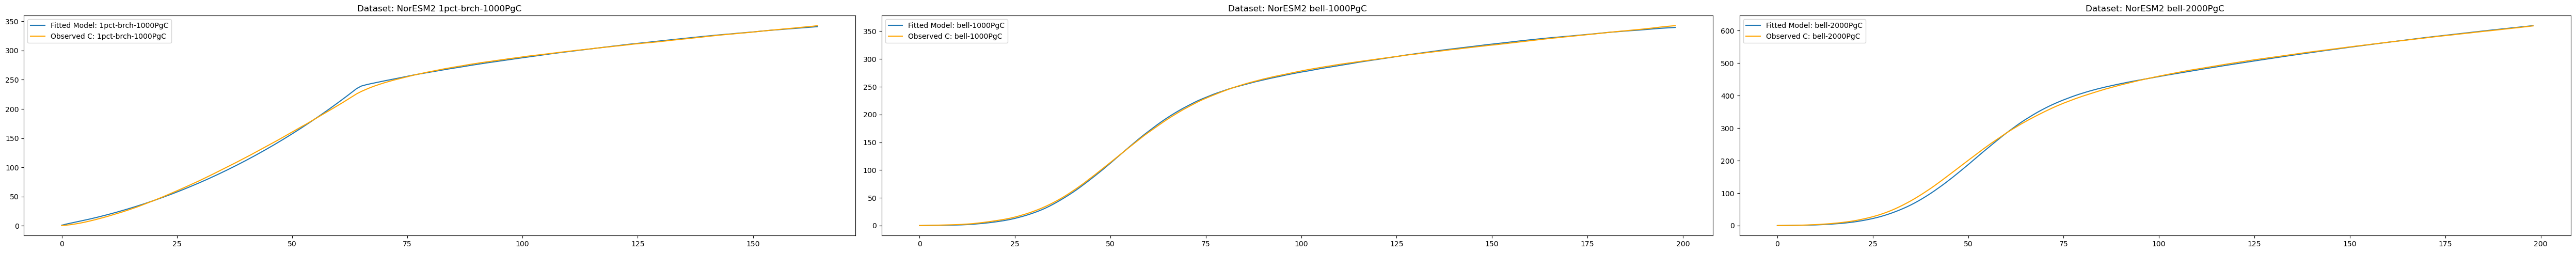

In [14]:
# Load data
datasets = ['1pct-brch-1000PgC', 'bell-1000PgC', 'bell-2000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-A1/fgco2_NorESM2-LM_esm-1pct-brch-1000PgC_0066-0167.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B1/fgco2_NorESM2-LM_esm-bell-1000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B3/fgco2_NorESM2-LM_esm-bell-2000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-A1/co2_NorESM2-LM_esm-1pct-brch-1000PgC_0066-0167.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B1/co2_NorESM2-LM_esm-bell-1000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B3/co2_NorESM2-LM_esm-bell-2000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'NorESM2', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  1.2551493960378812 1.6460219382753263 16.98687584334589 0.983358835252922
Optimized scaling values for 1pct-brch-2000PgC:  3.5293987390935433 0.27480303197258815 13.499372484292635 1.2709521291026407
Optimized scaling values for 1pct-brch-750PgC:  0.4624785907537207 2.2921773290000074 20.082748402646892 1.1022033118911483
Optimized scaling values for bell-1000PgC:  1.0715222728865286 1.7510918539018474 16.95623159503544 0.9894852933439615
Optimized scaling values for bell-2000PgC:  1.7089478578684325 1.0434943440884028 13.712505297461565 1.3112086321180378
Optimized scaling values for bell-750PgC:  2.390358528518106 0.6815393521457992 17.984477792059113 0.8706115859456558


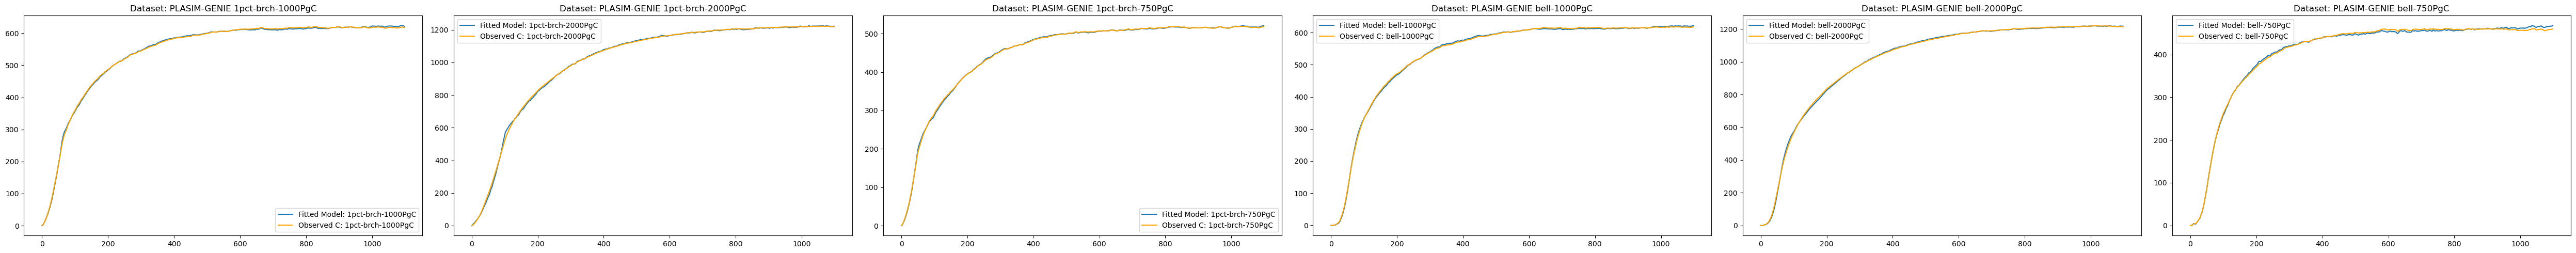

In [15]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'PLASIM-GENIE', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  2.195839765809747 0.5669832280327267 4.748919108140465 0.43332902768928644
Optimized scaling values for 1pct-brch-2000PgC:  3.4961077707032535 1.3147875267628534e-30 11323.404290617977 3075.18478710821
Optimized scaling values for 1pct-brch-750PgC:  1.5052599767221322 0.9811725814562737 4.90801398432622 0.37361293134133367
Optimized scaling values for 1pctCO2:  3.9674604107011877 3.049036612651825e-10 4.680069418190066e-09 64.29752246665102


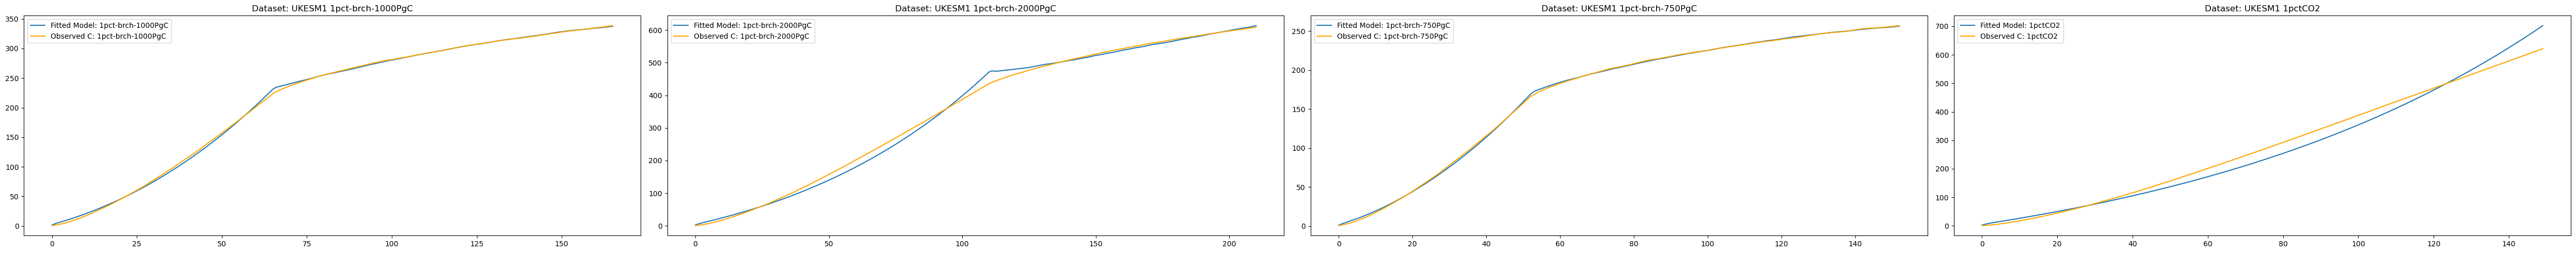

In [16]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', '1pctCO2']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-1000PgC/fgco2_UKESM1_esm-1pct-brch-1000PgC_1917_2016.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-2000PgC/fgco2_UKESM1_esm-1pct-brch-2000PgC_1962_2061.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-750PgC/fgco2_UKESM1_esm-1pct-brch-750PgC_1904_2003.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UKESM1/UKESM1_1pctCO2/fgco2_UKESM1_1pctCO2_1851_2000.csv', index_col=0).to_numpy().flatten(),

}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-1000PgC/co2_UKESM1_esm-1pct-brch-1000PgC_1917_2016.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-2000PgC/co2_UKESM1_esm-1pct-brch-2000PgC_1962_2061.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-750PgC/co2_UKESM1_esm-1pct-brch-750PgC_1904_2003.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UKESM1/UKESM1_1pctCO2/co2_UKESM1_1pctCO2_1851_2000.csv', index_col=0).to_numpy().flatten(),

}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'UKESM1', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


Optimized scaling values for 1pct-brch-1000PgC:  1.1627166739278425e-20 2.915703772144623 8.636775880580036 1.1306196614004567
Optimized scaling values for 1pct-brch-2000PgC:  2.5467520285686907 0.9398171059413537 6.099560754127617 1.3463657339968194
Optimized scaling values for 1pct-brch-750PgC:  7.04602579066045e-15 2.9840784883353457 9.606360911478522 1.0914856733367146
Optimized scaling values for bell-1000PgC:  1.5874571628157598e-19 2.82515792548144 8.639307946754634 1.1185204258391346
Optimized scaling values for bell-2000PgC:  0.3683732983126317 1.978012549480907 6.202879858747046 1.3219342164389423
Optimized scaling values for bell-750PgC:  1.7560552881047952e-21 2.9626238366813697 9.585385471264098 1.0873524102147827
Optimized scaling values for 1pctCO2:  4.670659172695022 1.8151225593876912e-09 3.5754647830383915e-11 128.26851914725


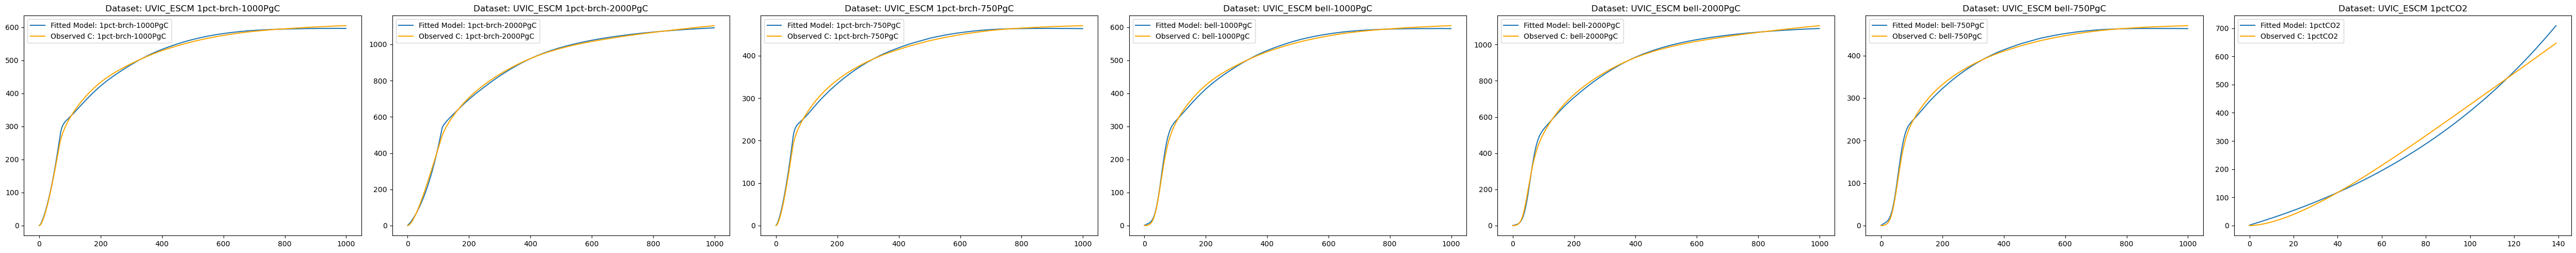

In [17]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC', '1pctCO2']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_1pct_bench_1850-1989.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pctCO2': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_1pct_bench_1850-1989.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_and_d_values_df = step_temp_model_fitting_procedure(dataset_name = 'UVIC_ESCM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_and_d_values_df = scale_and_d_values_df)


In [18]:
# Drop duplicate rows
scale_and_d_values_df = scale_and_d_values_df.drop_duplicates(keep='first')

# Print the cleaned DataFrame
print(scale_and_d_values_df)

scale_and_d_values_df.to_csv('scale_and_d_values.csv', index=False)

      Dataset         Experiment         alpha          beta         gamma  \
0      ACCESS            1pctCO2  4.490355e+00  2.242284e-10  3.138123e-09   
1      ACCESS  1pct-brch-1000PgC  2.524189e+00  5.189993e-01  5.085831e+00   
2      ACCESS   1pct-brch-750PgC  1.384394e+00  1.264749e+00  5.302745e+00   
3      ACCESS  1pct-brch-2000PgC  3.944624e+00  1.311502e-30  1.529564e+04   
4        CESM  1pct-brch-1000PgC  1.982307e+00  5.695520e-01  5.697297e+00   
..        ...                ...           ...           ...           ...   
60  UVIC_ESCM   1pct-brch-750PgC  7.046026e-15  2.984078e+00  9.606361e+00   
61  UVIC_ESCM       bell-1000PgC  1.587457e-19  2.825158e+00  8.639308e+00   
62  UVIC_ESCM       bell-2000PgC  3.683733e-01  1.978013e+00  6.202880e+00   
63  UVIC_ESCM        bell-750PgC  1.756055e-21  2.962624e+00  9.585385e+00   
64  UVIC_ESCM            1pctCO2  4.670659e+00  1.815123e-09  3.575465e-11   

          delta  
0     64.239596  
1      0.399295  
2      0.

In [29]:
import os


In [21]:
if not hasattr(vars, '__file__'):
    __file__ = os.getcwd()

scale_path = os.path.join(__file__, 'scale_and_d_values.csv')

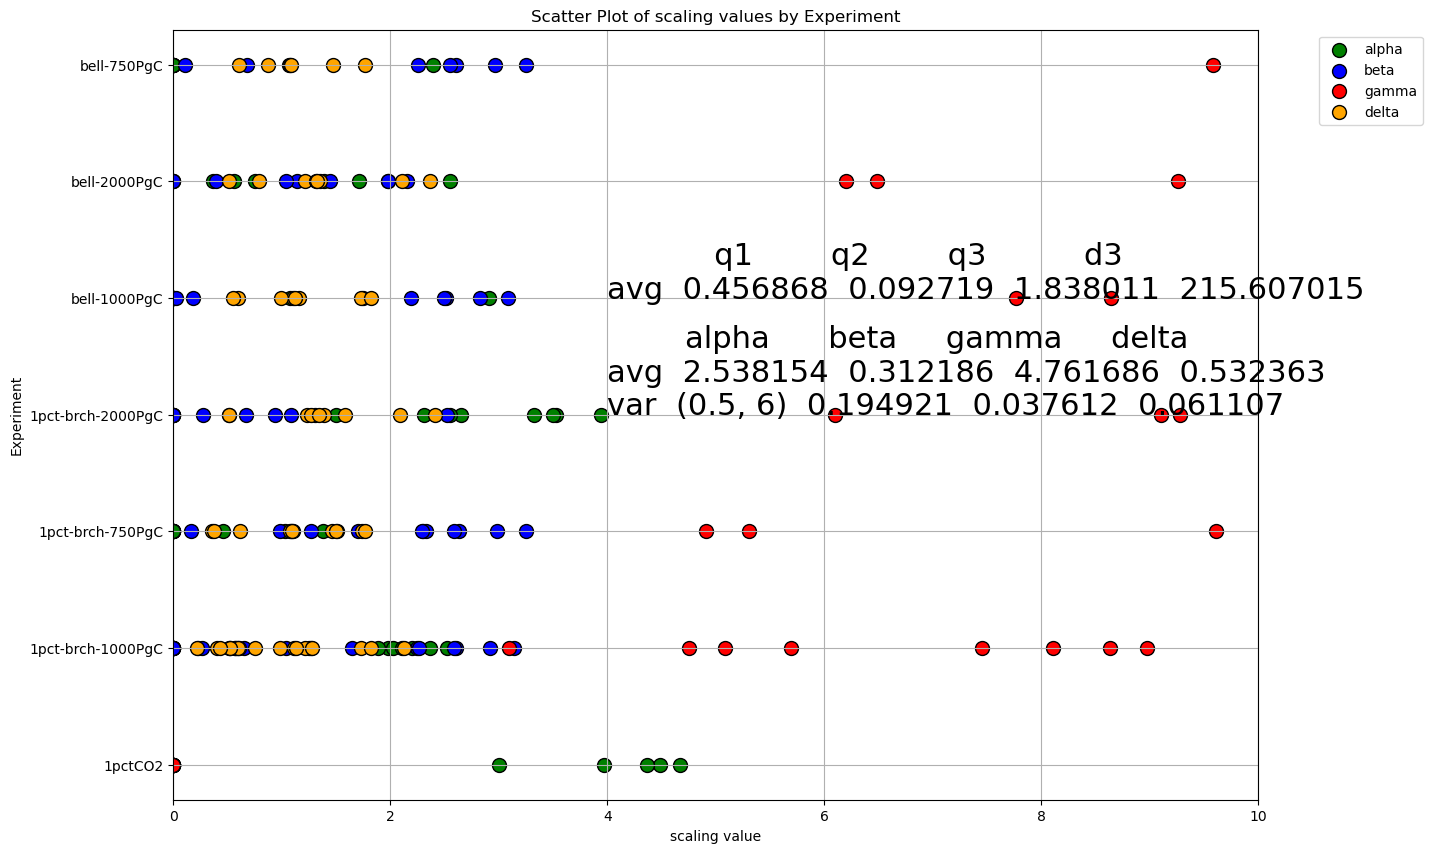

In [28]:
# === Data Preparation for Visualisation ===
# This section loads a DataFrame containing optimised scaling values (`scale_and_d_values_df`), 
# which represent the parameters alpha, beta, gamma, and delta for each experiment. 
# These parameters were optimised to match observed data, much like FaIR's probabilistic parameter tuning.
# Reference: FaIRv2.0.0, Section 4.1 - Parameter ensemble tuning

# Read in the scale and decay values DataFrame from the specified path


# Melt the DataFrame to have q values in one column
# scale_and_d_values_df = pd.read_csv('/Users/mert4908/Documents/FAIR-200/notebooks/scale_and_d_values.csv')
scale_and_d_values_df = pd.read_csv(scale_path)

# Transform (melt) the DataFrame to have 'scale_and_d_values' (alpha, beta, gamma, delta) in one column for plotting
df_melted = scale_and_d_values_df.melt(id_vars=['Dataset', 'Experiment'], value_vars=['alpha', 'beta', 'gamma', 'delta'],
                    var_name='scale_and_d_values', value_name='value')

# === Define Colours for Each Scaling Parameter ===
# Colours are assigned to each parameter to distinguish them in the scatter plot.
# This visualisation helps to assess the distribution of scaling values across experiments, 
# providing insights similar to those in FaIRv2.0.0's ensemble statistics.

# Define colors for each q value
scale_colors = {
    'alpha': 'green',
    'beta': 'blue',
    'gamma': 'red',
    'delta': 'orange'}

# === Scatter Plot of Scaling Values by Experiment ===
# This plot shows the optimised values of each scaling parameter across experiments, aiding in visual analysis of
# how different experiments affect these parameters. It mirrors FaIR’s visualisation of parameter spread across ensemble members.
# Reference: FaIRv2.0.0, Section 4.2 - Statistical analysis and visualisation of calibrated parameters

# Plotting
plt.figure(figsize=(14, 10))

# Plot each q value with its respective color
for scale_val, color in scale_colors.items():
    subset = df_melted[df_melted['scale_and_d_values'] == scale_val]
    plt.scatter(subset['value'], subset['Experiment'], 
                marker='o', color=color, 
                s=100,  # Size of scatter points
                label=scale_val,
                edgecolor='k')

plt.xlabel('scaling value')
plt.ylabel('Experiment')
plt.title('Scatter Plot of scaling values by Experiment')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.xlim(0, 10)
plt.grid(True)

# === Refining DataFrame Values for Statistical Summary ===
# Round values in `scale_and_d_values_df` to six decimal places for consistency

scale_and_d_values_df = scale_values_df.round(decimals=6)

# Replace zeros with NaN to avoid skewing statistics in subsequent calculations
scale_and_d_values_df = scale_values_df.replace(0, np.nan)

# === Calculate Mean and Variance for Each Parameter ===
# This section calculates the mean and variance for each parameter (alpha, beta, gamma, delta),
# providing insights into the spread of parameter values, similar to FaIR's statistical summaries.
# Reference: FaIRv2.0.0, Section 4.3 - Probabilistic summary statistics for parameter distributions

# stats_desc = pd.DataFrame([[scale_and_d_values_df.loc[:, 'alpha'].mean().round(decimals=6), scale_and_d_values_df.loc[:, 'beta'].mean().round(decimals=6), scale_and_d_values_df.loc[:, 'gamma'].mean().round(decimals=6), scale_and_d_values_df.loc[:, 'delta'].mean().round(decimals=6)], 
#                       [((scale_and_d_values_df.loc[:, 'alpha'])).var().round(decimals=6), ((scale_and_d_values_df.loc[:, 'beta'])).var().round(decimals=6), ((scale_and_d_values_df.loc[:, 'gamma'])).var().round(decimals=6), ((scale_and_d_values_df.loc[:, 'delta'])).var().round(decimals=6)]], ['avg', 'var'], ['alpha', 'beta', 'gamma', 'delta'])
stats_desc = pd.DataFrame([[scale_and_d_values_df.loc[:, 'alpha'].mean().round(decimals=6), scale_and_d_values_df.loc[:, 'beta'].mean().round(decimals=6), scale_and_d_values_df.loc[:, 'gamma'].mean().round(decimals=6), scale_and_d_values_df.loc[:, 'delta'].mean().round(decimals=6)], 
                      [(round((scale_and_d_values_df.loc[:, 'alpha'])).var(),6), 
                      round(((scale_and_d_values_df.loc[:, 'beta'])).var(),6), 
                      round(((scale_and_d_values_df.loc[:, 'gamma'])).var(),6), 
                      round(((scale_and_d_values_df.loc[:, 'delta'])).var(),6)]], 
                        ['avg', 'var'], ['alpha', 'beta', 'gamma', 'delta'])

# === Calculate q1, q2, q3, d3 Values Based on Scaling Parameters ===
# This transformation maps scaling values to model-specific parameters (q1, q2, q3, d3),
# which are used to model temperature response. These are analogous to FaIR’s `q` values,
# which scale the temperature response across various climate feedbacks.
# Reference: FaIRv2.0.0, Section 2.4 - Impulse response function scaling for temperature response

qs_desc = pd.DataFrame(stats_desc.iloc[0,:]*([0.180, 0.297, 0.386, 405]))
qs_desc = qs_desc.transpose()
qs_desc = qs_desc.rename(columns={'alpha': "q1", 'beta': "q2", 'gamma': "q3", 'delta': "d3"})

# === Display Calculated Statistics on the Plot ===
# These statistics are added to the plot for easy reference, aiding in the quick assessment of parameter distribution 
# and values, similar to how FaIR presents ensemble summaries for interpretability.

plt.text(4,3,(stats_desc), fontsize = 22)
plt.text(4,4,(qs_desc), fontsize = 22)

#  Save and display the plot
plt.savefig('Scaling Distribution Qs+D3')
plt.show()